In [1]:
import os
import os.path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from math import ceil
from random import random
import json

from shapely.geometry import Point
from shapely.geometry import shape
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm.notebook import tqdm
tqdm.pandas()

import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.features import shapes
from rasterio.features import dataset_features

from pyproj import CRS

import requests
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import shapely
import os
import sqlite3 as sl
import itertools
from tqdm.notebook import tqdm
tqdm.pandas()
from tqdm.auto import tqdm 

import logging
logging.getLogger().setLevel(logging.INFO)

from dotenv import load_dotenv
load_dotenv()

from bing_helper import Bing

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

In [2]:
# Convert single GeoDataFrame Polygon to GeoJSON
def get_mask_coords(gdf): 
    """Get the first polygon in a GeoDataFrame as GeoJSON."""
    return json.loads(gdf.to_json())['features'][0]['geometry']

In [3]:
def mask_popcenter_from_raster(gdf_entry, raster, tiff_out):
    
    out_img, out_transform = mask(
        dataset=raster, 
        shapes=get_mask_coords(gdf_entry), 
        crop=True)

    # Write out for usage a bit further onwards due to limitations in rasterio.
    out_meta = pop.meta.copy()
    out_meta.update({
        "driver": "GTiff",
         "height": out_img.shape[1],
         "width": out_img.shape[2],
         "transform": out_transform,
         "crs": pop.crs
    })

    with rasterio.open(tiff_out, "w", **out_meta) as dest:
        dest.write(out_img)

In [4]:
# Get population data for the whole world.
pop = rasterio.open(os.path.join(
    DROOT,
    '2-external',
    'GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0',
    'GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0.tif'))
pop.shape, pop.bounds, pop.crs.to_proj4()

((18000, 36082),
 BoundingBox(left=-18041000.0, bottom=-9000000.0, right=18041000.0, top=9000000.0),
 '+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True')

In [53]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities = cities.iloc[[2, 5, 8, 9, 15, 17]]
cities.head(20)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
5,Copenhagen,Kobenhavns Radhus,55.67537,12.56936,3090,DNK,2749
8,Barcelona,Ajuntament de Barcelona,41.38228,2.17532,2540,ESP,2051
9,Paris,Hôtel de Ville,48.85595,2.35167,5178,FRA,2046
15,Amsterdam,Stadsloket Centrum,52.36822,4.90000,3761,NLD,2167
17,Stockholm,Stadshus,59.32773,18.05362,3669,SWE,2973


In [54]:
def see_pop(x):
    out_img, out_transform = mask(dataset=pop, shapes=[x.geometry], crop=True)
    return out_img[out_img > -199].sum()

In [55]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

Brussels


INFO:root:Out of total 1330, 100.00% cached.


  0%|          | 0/1330 [00:00<?, ?it/s]

Gini: 0.19560486729585613
Copenhagen


INFO:root:Out of total 1940, 100.00% cached.


  0%|          | 0/1940 [00:00<?, ?it/s]

Gini: 0.2825636948336382
Barcelona


INFO:root:Out of total 2915, 100.00% cached.


  0%|          | 0/2915 [00:00<?, ?it/s]

Gini: 0.3299578238895508
Paris


INFO:root:Out of total 8190, 100.00% cached.


  0%|          | 0/8190 [00:00<?, ?it/s]

Gini: 0.3807568800838211
Amsterdam


INFO:root:Out of total 1725, 100.00% cached.


  0%|          | 0/1725 [00:00<?, ?it/s]

Gini: 0.2703161993664253
Stockholm


INFO:root:Out of total 1805, 100.00% cached.


  0%|          | 0/1805 [00:00<?, ?it/s]

Gini: 0.28707616808853165


Text(145.59722222222223, 0.5, 'Cum. Population %')

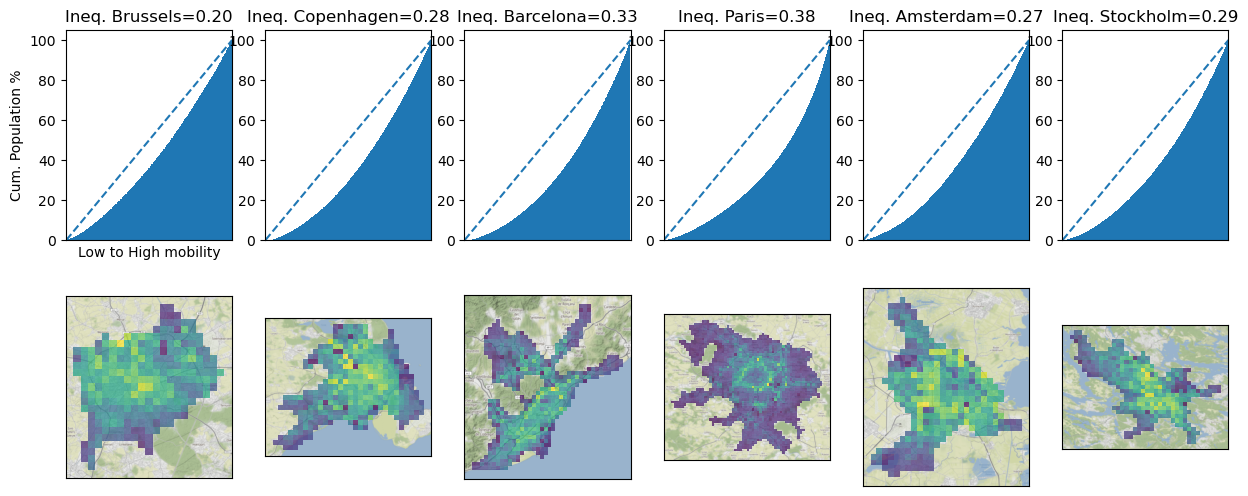

In [56]:
KEY = os.environ['BING_API_KEY']
CACHE = os.path.join(DROOT, '3-interim', 'bing_cache.db')
client = Bing(KEY, CACHE)

fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(15, 6))

j=0
gini_list = []

for i, city in cities.iterrows():
    print(city.City)
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', f'{city.ID_HDC_G0}.pcl'))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = range(5, 55, 10)
    modes_dt = [('driving', 'driving-peak', datetime(2023, 5, 2, 8, 30, 37)), 
#                 ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
#                 ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
#                 ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
#                 ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))
               ]
    
    batch      = list(itertools.product(origins, times, modes_dt))
    isochrones = client.get_isochrones_async(city.ID_HDC_G0, batch, buf_m=150)
    
    gdf        = gdf.reset_index().rename(columns={'index': 'pid', 'geometry': 'cell_geometry'})
    isochrones = isochrones.merge(gdf, on='pid')
    
    # Add population reach
    isochrones['pop'] = isochrones.to_crs(pop.crs).progress_apply(see_pop, axis=1)
    
    # Filter and plot
    f1 = isochrones[(isochrones.tt_mnts == 15) & (isochrones['modetime'] == 'driving-peak')]
    f1 = f1.sort_values('pop')
    
    # Register Gini Inequality
    cur_gini = gini(f1['pop'])
    print(f'Gini: {cur_gini}')
    gini_list.append((city.City, cur_gini))
    
    (f1.sort_values('pop')['pop'].cumsum() / f1['pop'].sum() * 100).plot.bar(ax=axs[0,j], width=1.0)
    axs[0,j].plot([0, len(f1)], [0, 100], linestyle='dashed')
    axs[0,j].set_xticks([])
    axs[0,j].set_title(f'Ineq. {city.City}={cur_gini:.2f}')

    f1.set_geometry('cell_geometry').plot(column='pop', ax=axs[1,j], alpha=0.7)
    ctx.add_basemap(axs[1,j], crs=f1.set_geometry('cell_geometry').crs, attribution=False)
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    
    j += 1

axs[0,0].set_xlabel('Low to High mobility')
axs[0,0].set_ylabel('Cum. Population %')

In [40]:
gini_list

[('Brussels', 0.19560486729585613),
 ('Berlin', 0.2213180788151678),
 ('Copenhagen', 0.2825636948336382),
 ('Barcelona', 0.3299578238895508),
 ('Paris', 0.3807568800838211),
 ('Amsterdam', 0.2703161993664253)]

In [ ]:
f1.set_geometry('cell_geometry').plot(column='pop')

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, mns in enumerate(range(5, 55, 10)):
    f1 = isochrones[(isochrones.tt_mnts == mns) & (isochrones['modetime'] == 'driving-peak')]
    f1.set_geometry('cell_geometry').plot(column='pop', alpha=0.7, ax=axs[i//3, i%3])
    ctx.add_basemap(ax=axs[i//3, i%3], crs=f1.set_geometry('cell_geometry').crs)